# Model training

For this demo we'll use the freely available Statlog (German Credit Data) Data Set, which can be downloaded from [Kaggle](https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)). This dataset classifies customers based on a set of attributes into two credit risk groups - good or bad. The majority of the attributes in this data set are categorical, and they are symbolically encoded. For example, attribute 1 represents the status of an existing checking account and can take one of the following values:

A11 : ... < 0 DM

A12 : 0 <= ... < 200 DM

A13 : ... >= 200 DM / salary assignments for at least 1 year

A14 : no checking account

A comprehensive list of all attributes and symbol codes is given in the [document](https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.doc) that accompanies the original dataset. 

The data we use in this demo has also been balanced and upsampled (see the [Data Generation](./data_generation.ipynb) notebook for reference).

## Seting up and connecting to Ray


Let's start by loading all the libraries needed for the notebook and by setting up default data paths.


In [1]:
import os
import ray
import glob
import eli5

import xgboost_ray as xgbr
import xgboost as xgb
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from ray import tune

DATA_ROOT = os.path.join("/mnt/data", os.environ["DOMINO_PROJECT_NAME"], "data") 
MODEL_ROOT = "/mnt/artifacts"
TUNE_ROOT = os.path.join("/mnt/data", os.environ["DOMINO_PROJECT_NAME"], "ray_results")

In this demo we'll use a dataset of a modest size (approx. 700 MB). Unfortunately, the standard Python libraries for data processing and machine learning Pandas and NumPy have never been designed with large datasets in mind. They rely on being able to fit the entire data in-memory with Pandas data frames having a hard theoretical limit of 100GB. In practice, the amount of data these libraries can handle is also restricted by the amount of physical memory available to the container that runs them, thus they'll have challenges handling even the 700 MB needed for our demo dataset. Trying to load our training data into a simple Pandas data frame using the code below will likely crash the Jupyter kernel.

``` 
# Do not run this code - it will likely crash the Jupyter kernel 
# (depending on the HW tier running the kernel)

import pandas as pd
import glob
import os

all_files = glob.glob(DATA_ROOT + "/train_data_*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

training_df = pd.concat(li, axis=0, ignore_index=True)
training_df.head()
```

To circumvent these restrictions Domino provides support for a number of industry-standard distributed computing frameworks like Ray, Dask, and Spark. In this demo we will use [On-Demand Ray](https://docs.dominodatalab.com/en/latest/user_guide/d13903/on-demand-ray-overview/). 

Ray is a general framework that enables you to quickly parallelize existing Python code, but it is also talked about as a "framework for building frameworks". Indeed, there are a growing number of domain-specific libraries that work on top of Ray.

![Ray](./images/ray.png)

For example:

* RaySGD - a library for distributed deep learning, which provides wrappers around PyTorch and TensorFlow
* RLlib - a library for reinforcement learning, which also natively supports TensorFlow, TensorFlow Eager, and PyTorch
* RayServe - a scalable, model-serving library
* Ray Tune - a hyperparameter optimization framework, most commonly used for deep and reinforcement learning

In this demo we'll use [Ray Tune](https://docs.ray.io/en/latest/tune/index.html) for hyperparameter optimisation and [XGBoost on Ray](https://github.com/ray-project/xgboost_ray) for model training.

In [2]:
# We'll set up Ray for 2 workers, 4 CPUs each (12 CPUs in total, counting the head node).

RAY_ACTORS = 3
RAY_CPUS_PER_ACTOR = 4

Let's connect to Ray.

In [3]:
if ray.is_initialized() == False:
    service_host = os.environ["RAY_HEAD_SERVICE_HOST"]
    service_port = os.environ["RAY_HEAD_SERVICE_PORT"]
    ray.init(f"ray://{service_host}:{service_port}")

Let's confirm we have the expected cluster configuration.

In [4]:
ray.nodes()

[{'NodeID': '485fbd09ebfd9a4b788e649ecf80e6a7bd43bf856b56ee47a94845c2',
  'Alive': True,
  'NodeManagerAddress': '100.64.46.131',
  'NodeManagerHostname': 'ray-687e6c2cf9ac5a56add949fa-ray-worker-2',
  'NodeManagerPort': 2385,
  'ObjectManagerPort': 2384,
  'ObjectStoreSocketName': '/tmp/ray/session_2025-07-21_09-35-11_247340_1/sockets/plasma_store',
  'RayletSocketName': '/tmp/ray/session_2025-07-21_09-35-11_247340_1/sockets/raylet',
  'MetricsExportPort': 50925,
  'NodeName': '100.64.46.131',
  'alive': True,
  'Resources': {'node:100.64.46.131': 1.0,
   'object_store_memory': 4766361600.0,
   'CPU': 4.0,
   'memory': 11121510400.0}},
 {'NodeID': '9457e4c73e6f097dbd84e3d8211445f2fbe304db684fc55cb2f869a5',
  'Alive': True,
  'NodeManagerAddress': '100.64.87.68',
  'NodeManagerHostname': 'ray-687e6c2cf9ac5a56add949fa-ray-worker-1',
  'NodeManagerPort': 2385,
  'ObjectManagerPort': 2384,
  'ObjectStoreSocketName': '/tmp/ray/session_2025-07-21_09-35-11_247340_1/sockets/plasma_store',
  '

Now let's create a list of all the shards for our training, validation, and test sets.

In [5]:
train_files = glob.glob(os.path.join(DATA_ROOT, "train_data*"))
val_files = glob.glob(os.path.join(DATA_ROOT, "validation_data*"))

test_file = os.path.join(DATA_ROOT, "test_data.csv")

target_col = "credit"

XGBoost-Ray provides a drop-in replacement for XGBoost's train function. To pass data, instead of using xgb.DMatrix we will have to use xgboost_ray.RayDMatrix. The RayDMatrix lazy loads data and stores it sharded in the Ray object store. The Ray XGBoost actors then access these shards to run their training on. Let's wrap our training, validation, and test sets into RayDMatrix objects.

In [6]:
# Although it is possible to specify the number of Actors when initializing the RayDMatrix, it is not necessary,
#  and can cause a conflict if different from the number of Actors chosen for training.

rdm_train = xgbr.RayDMatrix(train_files, label=target_col)
rdm_val = xgbr.RayDMatrix(val_files, label=target_col)

df_test = pd.read_csv(test_file)
rdm_test = xgbr.RayDMatrix(df_test, label=target_col)

In [7]:
# This function verifies whether the data will support splitting into a given number of shards.
# We use this to validate that our splits are compatible with the selected Ray cluster configuraiton (i.e. number of Ray nodes)

rdm_train.assert_enough_shards_for_actors(len(train_files))
rdm_train.assert_enough_shards_for_actors(len(val_files))

In [8]:
print("Will the read be distributed?", rdm_train.distributed)
print("Has any data been read yet?", rdm_train.loaded) # Remember, lazy loading

Will the read be distributed? True
Has any data been read yet? False


## Model training

Let's first try to train a single model in order to validate our setup. Feel free to switch to the Ray Web UI tab and observe the distribution of workload among the individual Ray nodes.

A few things to note:

* We are using “binary:logistic” – logistic regression for binary classification (*credit* is in {0,1}), which outputs probability
* We are calculating both logloss and error as evaluation metrics. They don't impact the model fitting
* We are passing the cluster topology via the xgb_ray_params objects so that the workload can be correctly distributed


In [9]:
# Set a few hyperparameters to specific values
param = {
    "seed":1234,
    "max_depth":3,
    "eta":0.1,
    "objective": "binary:logistic",
    "eval_metric": ["logloss", "error"]
}

xgb_ray_params = xgbr.RayParams(
    num_actors=RAY_ACTORS,
    cpus_per_actor=RAY_CPUS_PER_ACTOR
)

# Train the model
evals_result = {}

bst = xgbr.train(
    param,
    rdm_train,
    num_boost_round=50,
    verbose_eval=True,
    evals_result=evals_result,
    evals =[(rdm_train, "train"), (rdm_val, "val")],
    ray_params=xgb_ray_params
)

print("Final training error: {:.4f}".format(evals_result["train"]["error"][-1]))
print("Final validation error: {:.4f}".format(evals_result["val"]["error"][-1]))

/opt/conda/lib/python3.9/site-packages/xgboost_ray/util.py:89: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
Use get_node_id() instead
  current_node_id = ray.get_runtime_context().node_id.hex()
(_wrapped pid=21740) 2025-07-21 14:57:23,752	INFO main.py:1047 -- [RayXGBoost] Created 3 new actors (3 total actors). Waiting until actors are ready for training.
(_wrapped pid=21740) 2025-07-21 14:57:28,696	INFO main.py:1092 -- [RayXGBoost] Starting XGBoost training.
(_RemoteRayXGBoostActor pid=2450, ip=100.64.46.131) [14:57:28] task [xgboost.ray]:135481784825408 got new rank 0
(_RemoteRayXGBoostActor pid=2709, ip=100.64.79.49) [14:57:28] task [xgboost.ray]:123746484561760 got new rank 1
(_RemoteRayXGBoostActor pid=2392, ip=100.64.87.68) [14:57:28] task [xgboost.ray]:139553292388288 got new rank 2


(_wrapped pid=21740) [0]	train-logloss:0.65890	train-error:0.22747	val-logloss:0.65631	val-error:0.20883
(_wrapped pid=21740) [1]	train-logloss:0.63105	train-error:0.22322	val-logloss:0.62528	val-error:0.20100
(_wrapped pid=21740) [2]	train-logloss:0.60865	train-error:0.22340	val-logloss:0.60093	val-error:0.21037
(_wrapped pid=21740) [3]	train-logloss:0.58683	train-error:0.20024	val-logloss:0.57770	val-error:0.17753
(_wrapped pid=21740) [4]	train-logloss:0.56887	train-error:0.19834	val-logloss:0.55733	val-error:0.17213
(_wrapped pid=21740) [5]	train-logloss:0.55296	train-error:0.18635	val-logloss:0.54088	val-error:0.16274
(_wrapped pid=21740) [6]	train-logloss:0.53873	train-error:0.18173	val-logloss:0.52620	val-error:0.15723
(_wrapped pid=21740) [7]	train-logloss:0.52442	train-error:0.17974	val-logloss:0.51060	val-error:0.16108
(_wrapped pid=21740) [8]	train-logloss:0.51177	train-error:0.17802	val-logloss:0.49672	val-error:0.16424
(_wrapped pid=21740) [9]	train-logloss:0.50048	train-er

(_wrapped pid=21740) 2025-07-21 14:57:59,200	INFO main.py:1175 -- Training in progress (30 seconds since last restart).


(_wrapped pid=21740) [33]	train-logloss:0.34910	train-error:0.12610	val-logloss:0.33604	val-error:0.11894
(_wrapped pid=21740) [34]	train-logloss:0.34563	train-error:0.12341	val-logloss:0.33241	val-error:0.11427
(_wrapped pid=21740) [35]	train-logloss:0.34209	train-error:0.12078	val-logloss:0.32824	val-error:0.10792
(_wrapped pid=21740) [36]	train-logloss:0.33887	train-error:0.11931	val-logloss:0.32486	val-error:0.10715
(_wrapped pid=21740) [37]	train-logloss:0.33525	train-error:0.12169	val-logloss:0.32043	val-error:0.10795
(_wrapped pid=21740) [38]	train-logloss:0.33301	train-error:0.11706	val-logloss:0.31812	val-error:0.10324
(_wrapped pid=21740) [39]	train-logloss:0.32948	train-error:0.11211	val-logloss:0.31456	val-error:0.09856
(_wrapped pid=21740) [40]	train-logloss:0.32674	train-error:0.11108	val-logloss:0.31153	val-error:0.09692
(_wrapped pid=21740) [41]	train-logloss:0.32437	train-error:0.10827	val-logloss:0.30940	val-error:0.09539
(_wrapped pid=21740) [42]	train-logloss:0.3216

(_wrapped pid=21740) 2025-07-21 14:58:11,780	INFO main.py:1587 -- [RayXGBoost] Finished XGBoost training on training data with total N=2,100,000 in 48.98 seconds (43.07 pure XGBoost training time).


Final training error: 0.1003
Final validation error: 0.0876


Now that we've confirmed the pipeline we can move onto performing some hyperparameter tuning for finding an optimal model.

## Hyperparameter tuning

Hyperparameter tuning requires training many copies of a model, each with a different set of hyperparameters, and seeing which one performs the best. Each time we train a model, that is one trial. To do this in our Ray cluster, we can specify what resources to use:

* Required CPU, Memory, and/or GPU per trial
* Where to store intermediate results

The `xgboost_ray` library includes a built-in method for generating a `PlacementGroupFactory` to pass to Ray Tune, based on the `RayParams` object used for XGBoost training. Resources can also be requested in a simpler dictionary format, e.g. `{"cpu": 2.0}`. As described in the [Tune docs](https://docs.ray.io/en/latest/tune/tutorials/tune-resources.html), by default Ray Tune will schedule N concurrent trials, using 1 CPU per trial, where N is the total number of CPUs available in the cluster.

In [10]:
# Get the placement group factory to pass to Ray Tune
# Notice how the tune resources are 1 CPU greater!
xgb_tune_resources = xgb_ray_params.get_tune_resources()
print(f"We will pass a {type(xgb_tune_resources)} to Ray Tune.")
print(f"It will request {xgb_tune_resources.required_resources} per trial.")
print(f"The cluster has {ray.cluster_resources()['CPU']} CPU total.")

We will pass a <class 'ray.tune.execution.placement_groups.PlacementGroupFactory'> to Ray Tune.
It will request {'CPU': 12.0} per trial.
The cluster has 12.0 CPU total.


In [11]:
print("Saving intermediate tune results to", TUNE_ROOT)

Saving intermediate tune results to /mnt/data/Credit-Risk-Model/ray_results


In this demo we will use a very simple search strategy called *a grid search*. This involves searching over a predefined grid of hyperparameter choices - and it's easy to imaging writing a simple for loop to implement it. However, for $n$ choices each of $k$ hyperparameters, a full grid search requires $O(n^k)$ trials and quickly becomes prohibitively expensive.

Ray Tune provides much more sophisticated options for optimization. Instead of pre-defining a fixed grid to search over, Ray Tune allows specifying a [search space](https://docs.ray.io/en/releases-1.11.0/tune/key-concepts.html#search-spaces) with distributions of parameters. The number of trials over the search space is specified at a later stage in the `run()` function.

In [12]:
config = {
    "seed": 1234,
    "eta": tune.loguniform(3e-3, 3e-1),
    "max_depth": tune.randint(2, 6),
    "objective": "binary:logistic",
    "eval_metric": ["logloss", "error"]
}

For each trial, a config dictionary like the one we just defined, with the single value for each hyperparameter chosen for that trial, will be passed into a [trainable](https://docs.ray.io/en/releases-1.11.0/tune/key-concepts.html#search-algorithms) that we define and pass to Ray Tune. Below we have defined such a function to wrap training a single XGBoost model on Ray.

In [13]:
def my_trainer(config):
    evals_result = {}
    bst = xgbr.train(
        params=config,
        dtrain=rdm_train,
        num_boost_round=50,
        evals_result=evals_result,
        evals=[(rdm_train, "train"), (rdm_val, "val")],
        ray_params=xgb_ray_params
    )
    bst.save_model("model.xgb") # This will go into the TUNE_ROOT directory

Finally, we can now run our trials. Here we bring together the previous few sections:

* The training function
* The search space defined in the config
* The resources per trial and results location

We control the number of trials over the search space via the `num_samples` argument (currently set to 10). We also rank the models based on the lowest validation set error.

In [14]:
analysis = tune.run(
    my_trainer,
    config=config,
    resources_per_trial=xgb_tune_resources,
    local_dir=TUNE_ROOT,
    metric="val-error",
    mode="min",
    num_samples=10,
    verbose=1,
    progress_reporter=tune.JupyterNotebookReporter(overwrite=True)
)

(run pid=21740) UserWarning: The `local_dir` argument of `Experiment is deprecated. Use `storage_path` or set the `TUNE_RESULT_DIR` environment variable instead.
(_RemoteRayXGBoostActor pid=2573, ip=100.64.46.131) [14:58:23] task [xgboost.ray]:139066194221952 got new rank 0
(_RemoteRayXGBoostActor pid=2794, ip=100.64.79.49) [14:58:23] task [xgboost.ray]:134662570555136 got new rank 1
(_RemoteRayXGBoostActor pid=2474, ip=100.64.87.68) [14:58:23] task [xgboost.ray]:125341759236944 got new rank 2


(my_trainer pid=2530, ip=100.64.46.131) [0]	train-logloss:0.69218	train-error:0.30285	val-logloss:0.69213	val-error:0.29079
(my_trainer pid=2530, ip=100.64.46.131) [1]	train-logloss:0.69123	train-error:0.30285	val-logloss:0.69112	val-error:0.29079
(my_trainer pid=2530, ip=100.64.46.131) [2]	train-logloss:0.69028	train-error:0.30285	val-logloss:0.69012	val-error:0.29079


(my_trainer pid=2530, ip=100.64.46.131) [3]	train-logloss:0.68934	train-error:0.30285	val-logloss:0.68912	val-error:0.29079
(my_trainer pid=2530, ip=100.64.46.131) [4]	train-logloss:0.68840	train-error:0.30285	val-logloss:0.68814	val-error:0.29079
(my_trainer pid=2530, ip=100.64.46.131) [5]	train-logloss:0.68748	train-error:0.26686	val-logloss:0.68714	val-error:0.24841
(my_trainer pid=2530, ip=100.64.46.131) [6]	train-logloss:0.68656	train-error:0.30285	val-logloss:0.68617	val-error:0.29079
(my_trainer pid=2530, ip=100.64.46.131) [7]	train-logloss:0.68564	train-error:0.26686	val-logloss:0.68519	val-error:0.24841
(my_trainer pid=2530, ip=100.64.46.131) [8]	train-logloss:0.68473	train-error:0.26686	val-logloss:0.68423	val-error:0.24841
(my_trainer pid=2530, ip=100.64.46.131) [9]	train-logloss:0.68383	train-error:0.26686	val-logloss:0.68326	val-error:0.24841
(my_trainer pid=2530, ip=100.64.46.131) [10]	train-logloss:0.68294	train-error:0.26686	val-logloss:0.68231	val-error:0.24841
(my_tra

(my_trainer pid=2530, ip=100.64.46.131) 2025-07-21 14:58:53,817	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=2530, ip=100.64.46.131) [34]	train-logloss:0.66317	train-error:0.26686	val-logloss:0.66121	val-error:0.24841
(my_trainer pid=2530, ip=100.64.46.131) [35]	train-logloss:0.66242	train-error:0.26686	val-logloss:0.66039	val-error:0.24841
(my_trainer pid=2530, ip=100.64.46.131) [36]	train-logloss:0.66167	train-error:0.26686	val-logloss:0.65959	val-error:0.24841
(my_trainer pid=2530, ip=100.64.46.131) [37]	train-logloss:0.66092	train-error:0.26686	val-logloss:0.65878	val-error:0.24841
(my_trainer pid=2530, ip=100.64.46.131) [38]	train-logloss:0.66018	train-error:0.26686	val-logloss:0.65798	val-error:0.24841
(my_trainer pid=2530, ip=100.64.46.131) [39]	train-logloss:0.65944	train-error:0.26686	val-logloss:0.65719	val-error:0.24841
(my_trainer pid=2530, ip=100.64.46.131) [40]	train-logloss:0.65871	train-error:0.26686	val-logloss:0.65642	val-error:0.24841
(my_trainer pid=2530, ip=100.64.46.131) [41]	train-logloss:0.65798	train-error:0.26686	val-logloss:0.65562	val-error:0.24841


(_RemoteRayXGBoostActor pid=2717, ip=100.64.46.131) [14:59:11] task [xgboost.ray]:138817071114080 got new rank 0
(_RemoteRayXGBoostActor pid=2874, ip=100.64.79.49) [14:59:12] task [xgboost.ray]:132874186901200 got new rank 1
(_RemoteRayXGBoostActor pid=2637, ip=100.64.87.68) [14:59:12] task [xgboost.ray]:139715675197056 got new rank 2


(my_trainer pid=2530, ip=100.64.46.131) [0]	train-logloss:0.68832	train-error:0.30285	val-logloss:0.68805	val-error:0.29079
(my_trainer pid=2530, ip=100.64.46.131) [1]	train-logloss:0.68368	train-error:0.26686	val-logloss:0.68307	val-error:0.24841
(my_trainer pid=2530, ip=100.64.46.131) [2]	train-logloss:0.67918	train-error:0.26686	val-logloss:0.67831	val-error:0.24841
(my_trainer pid=2530, ip=100.64.46.131) [3]	train-logloss:0.67486	train-error:0.26686	val-logloss:0.67365	val-error:0.24841
(my_trainer pid=2530, ip=100.64.46.131) [4]	train-logloss:0.67066	train-error:0.26686	val-logloss:0.66921	val-error:0.24841
(my_trainer pid=2530, ip=100.64.46.131) [5]	train-logloss:0.66662	train-error:0.26686	val-logloss:0.66485	val-error:0.24841
(my_trainer pid=2530, ip=100.64.46.131) [6]	train-logloss:0.66271	train-error:0.26686	val-logloss:0.66069	val-error:0.24841
(my_trainer pid=2530, ip=100.64.46.131) [7]	train-logloss:0.65893	train-error:0.26686	val-logloss:0.65670	val-error:0.24841
(my_trai

(my_trainer pid=2530, ip=100.64.46.131) 2025-07-21 14:59:42,497	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=2530, ip=100.64.46.131) [34]	train-logloss:0.58342	train-error:0.24894	val-logloss:0.57649	val-error:0.23061
(my_trainer pid=2530, ip=100.64.46.131) [35]	train-logloss:0.58127	train-error:0.24894	val-logloss:0.57420	val-error:0.23061
(my_trainer pid=2530, ip=100.64.46.131) [36]	train-logloss:0.57920	train-error:0.24894	val-logloss:0.57215	val-error:0.23061
(my_trainer pid=2530, ip=100.64.46.131) [37]	train-logloss:0.57723	train-error:0.22499	val-logloss:0.57014	val-error:0.20556
(my_trainer pid=2530, ip=100.64.46.131) [38]	train-logloss:0.57522	train-error:0.22499	val-logloss:0.56819	val-error:0.20556
(my_trainer pid=2530, ip=100.64.46.131) [39]	train-logloss:0.57331	train-error:0.23637	val-logloss:0.56621	val-error:0.21971
(my_trainer pid=2530, ip=100.64.46.131) [40]	train-logloss:0.57138	train-error:0.23185	val-logloss:0.56433	val-error:0.21578
(my_trainer pid=2530, ip=100.64.46.131) [41]	train-logloss:0.56955	train-error:0.22838	val-logloss:0.56241	val-error:0.21500


(_RemoteRayXGBoostActor pid=2943, ip=100.64.46.131) [15:00:01] task [xgboost.ray]:124846178154432 got new rank 0
(_RemoteRayXGBoostActor pid=2954, ip=100.64.79.49) [15:00:01] task [xgboost.ray]:126658414352080 got new rank 1
(_RemoteRayXGBoostActor pid=2719, ip=100.64.87.68) [15:00:01] task [xgboost.ray]:137908734742480 got new rank 2


(my_trainer pid=2530, ip=100.64.46.131) [0]	train-logloss:0.69037	train-error:0.16109	val-logloss:0.69033	val-error:0.15954
(my_trainer pid=2530, ip=100.64.46.131) [1]	train-logloss:0.68761	train-error:0.16109	val-logloss:0.68754	val-error:0.15954
(my_trainer pid=2530, ip=100.64.46.131) [2]	train-logloss:0.68489	train-error:0.16109	val-logloss:0.68481	val-error:0.15954
(my_trainer pid=2530, ip=100.64.46.131) [3]	train-logloss:0.68221	train-error:0.15997	val-logloss:0.68211	val-error:0.15799
(my_trainer pid=2530, ip=100.64.46.131) [4]	train-logloss:0.67954	train-error:0.15997	val-logloss:0.67940	val-error:0.15799
(my_trainer pid=2530, ip=100.64.46.131) [5]	train-logloss:0.67691	train-error:0.15846	val-logloss:0.67676	val-error:0.15730
(my_trainer pid=2530, ip=100.64.46.131) [6]	train-logloss:0.67430	train-error:0.15997	val-logloss:0.67411	val-error:0.15799
(my_trainer pid=2530, ip=100.64.46.131) [7]	train-logloss:0.67172	train-error:0.15846	val-logloss:0.67151	val-error:0.15730
(my_trai

(my_trainer pid=2530, ip=100.64.46.131) 2025-07-21 15:00:32,097	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=2530, ip=100.64.46.131) [32]	train-logloss:0.61479	train-error:0.13704	val-logloss:0.61124	val-error:0.12212
(my_trainer pid=2530, ip=100.64.46.131) [33]	train-logloss:0.61274	train-error:0.13703	val-logloss:0.60905	val-error:0.12133
(my_trainer pid=2530, ip=100.64.46.131) [34]	train-logloss:0.61071	train-error:0.13398	val-logloss:0.60695	val-error:0.11743
(my_trainer pid=2530, ip=100.64.46.131) [35]	train-logloss:0.60869	train-error:0.13026	val-logloss:0.60473	val-error:0.11358
(my_trainer pid=2530, ip=100.64.46.131) [36]	train-logloss:0.60669	train-error:0.13105	val-logloss:0.60267	val-error:0.11358
(my_trainer pid=2530, ip=100.64.46.131) [37]	train-logloss:0.60471	train-error:0.12867	val-logloss:0.60054	val-error:0.11123
(my_trainer pid=2530, ip=100.64.46.131) [38]	train-logloss:0.60275	train-error:0.12800	val-logloss:0.59852	val-error:0.11046
(my_trainer pid=2530, ip=100.64.46.131) [39]	train-logloss:0.60079	train-error:0.12947	val-logloss:0.59637	val-error:0.11203


(_RemoteRayXGBoostActor pid=3170, ip=100.64.46.131) [15:00:53] task [xgboost.ray]:136441272161856 got new rank 0
(_RemoteRayXGBoostActor pid=3037, ip=100.64.79.49) [15:00:53] task [xgboost.ray]:136254727475264 got new rank 1
(_RemoteRayXGBoostActor pid=2799, ip=100.64.87.68) [15:00:53] task [xgboost.ray]:136576444458512 got new rank 2


(my_trainer pid=2530, ip=100.64.46.131) [0]	train-logloss:0.62310	train-error:0.16109	val-logloss:0.62218	val-error:0.15954
(my_trainer pid=2530, ip=100.64.46.131) [1]	train-logloss:0.56923	train-error:0.14666	val-logloss:0.56451	val-error:0.13700
(my_trainer pid=2530, ip=100.64.46.131) [2]	train-logloss:0.52654	train-error:0.14451	val-logloss:0.52005	val-error:0.13695
(my_trainer pid=2530, ip=100.64.46.131) [3]	train-logloss:0.48949	train-error:0.13604	val-logloss:0.48019	val-error:0.12513
(my_trainer pid=2530, ip=100.64.46.131) [4]	train-logloss:0.45619	train-error:0.12288	val-logloss:0.44545	val-error:0.10490
(my_trainer pid=2530, ip=100.64.46.131) [5]	train-logloss:0.42660	train-error:0.10602	val-logloss:0.41596	val-error:0.08765
(my_trainer pid=2530, ip=100.64.46.131) [6]	train-logloss:0.40180	train-error:0.09786	val-logloss:0.39114	val-error:0.08528
(my_trainer pid=2530, ip=100.64.46.131) [7]	train-logloss:0.38114	train-error:0.09123	val-logloss:0.36839	val-error:0.07831
(my_trai

(my_trainer pid=2530, ip=100.64.46.131) 2025-07-21 15:01:24,157	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=2530, ip=100.64.46.131) [32]	train-logloss:0.16523	train-error:0.02697	val-logloss:0.15461	val-error:0.01808
(my_trainer pid=2530, ip=100.64.46.131) [33]	train-logloss:0.16006	train-error:0.02824	val-logloss:0.14991	val-error:0.01729
(my_trainer pid=2530, ip=100.64.46.131) [34]	train-logloss:0.15789	train-error:0.02745	val-logloss:0.14760	val-error:0.01729
(my_trainer pid=2530, ip=100.64.46.131) [35]	train-logloss:0.15552	train-error:0.02789	val-logloss:0.14530	val-error:0.01808
(my_trainer pid=2530, ip=100.64.46.131) [36]	train-logloss:0.15341	train-error:0.02585	val-logloss:0.14314	val-error:0.01729
(my_trainer pid=2530, ip=100.64.46.131) [37]	train-logloss:0.14865	train-error:0.02484	val-logloss:0.13801	val-error:0.01571
(my_trainer pid=2530, ip=100.64.46.131) [38]	train-logloss:0.14575	train-error:0.02551	val-logloss:0.13519	val-error:0.01729
(my_trainer pid=2530, ip=100.64.46.131) [39]	train-logloss:0.14364	train-error:0.02528	val-logloss:0.13294	val-error:0.01650


(_RemoteRayXGBoostActor pid=3435, ip=100.64.46.131) [15:01:44] task [xgboost.ray]:139526081431536 got new rank 0
(_RemoteRayXGBoostActor pid=3117, ip=100.64.79.49) [15:01:45] task [xgboost.ray]:137378900923968 got new rank 1
(_RemoteRayXGBoostActor pid=2881, ip=100.64.87.68) [15:01:45] task [xgboost.ray]:133721303619568 got new rank 2


(my_trainer pid=2530, ip=100.64.46.131) [0]	train-logloss:0.69073	train-error:0.30285	val-logloss:0.69059	val-error:0.29079
(my_trainer pid=2530, ip=100.64.46.131) [1]	train-logloss:0.68836	train-error:0.30285	val-logloss:0.68809	val-error:0.29079
(my_trainer pid=2530, ip=100.64.46.131) [2]	train-logloss:0.68604	train-error:0.26686	val-logloss:0.68560	val-error:0.24841
(my_trainer pid=2530, ip=100.64.46.131) [3]	train-logloss:0.68375	train-error:0.26686	val-logloss:0.68318	val-error:0.24841
(my_trainer pid=2530, ip=100.64.46.131) [4]	train-logloss:0.68150	train-error:0.26686	val-logloss:0.68076	val-error:0.24841
(my_trainer pid=2530, ip=100.64.46.131) [5]	train-logloss:0.67929	train-error:0.26686	val-logloss:0.67843	val-error:0.24841
(my_trainer pid=2530, ip=100.64.46.131) [6]	train-logloss:0.67712	train-error:0.26686	val-logloss:0.67609	val-error:0.24841
(my_trainer pid=2530, ip=100.64.46.131) [7]	train-logloss:0.67499	train-error:0.26686	val-logloss:0.67383	val-error:0.24841
(my_trai

(my_trainer pid=2530, ip=100.64.46.131) 2025-07-21 15:02:15,607	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=2530, ip=100.64.46.131) [33]	train-logloss:0.62946	train-error:0.26122	val-logloss:0.62507	val-error:0.24774
(my_trainer pid=2530, ip=100.64.46.131) [34]	train-logloss:0.62800	train-error:0.26122	val-logloss:0.62347	val-error:0.24774
(my_trainer pid=2530, ip=100.64.46.131) [35]	train-logloss:0.62651	train-error:0.26380	val-logloss:0.62188	val-error:0.24935
(my_trainer pid=2530, ip=100.64.46.131) [36]	train-logloss:0.62508	train-error:0.26122	val-logloss:0.62036	val-error:0.24774
(my_trainer pid=2530, ip=100.64.46.131) [37]	train-logloss:0.62363	train-error:0.26380	val-logloss:0.61881	val-error:0.24935
(my_trainer pid=2530, ip=100.64.46.131) [38]	train-logloss:0.62223	train-error:0.26380	val-logloss:0.61733	val-error:0.24935
(my_trainer pid=2530, ip=100.64.46.131) [39]	train-logloss:0.62081	train-error:0.26380	val-logloss:0.61581	val-error:0.24935
(my_trainer pid=2530, ip=100.64.46.131) [40]	train-logloss:0.61944	train-error:0.26380	val-logloss:0.61430	val-error:0.24935


(_RemoteRayXGBoostActor pid=3657, ip=100.64.46.131) [15:02:35] task [xgboost.ray]:133317225268224 got new rank 0
(_RemoteRayXGBoostActor pid=3200, ip=100.64.79.49) [15:02:35] task [xgboost.ray]:129056938993456 got new rank 1
(_RemoteRayXGBoostActor pid=2963, ip=100.64.87.68) [15:02:35] task [xgboost.ray]:133012734077824 got new rank 2


(my_trainer pid=2530, ip=100.64.46.131) [0]	train-logloss:0.68822	train-error:0.22747	val-logloss:0.68786	val-error:0.20883
(my_trainer pid=2530, ip=100.64.46.131) [1]	train-logloss:0.68342	train-error:0.22747	val-logloss:0.68270	val-error:0.20883
(my_trainer pid=2530, ip=100.64.46.131) [2]	train-logloss:0.67892	train-error:0.22331	val-logloss:0.67770	val-error:0.20021
(my_trainer pid=2530, ip=100.64.46.131) [3]	train-logloss:0.67454	train-error:0.22331	val-logloss:0.67282	val-error:0.20021
(my_trainer pid=2530, ip=100.64.46.131) [4]	train-logloss:0.67006	train-error:0.22331	val-logloss:0.66800	val-error:0.20021
(my_trainer pid=2530, ip=100.64.46.131) [5]	train-logloss:0.66588	train-error:0.22331	val-logloss:0.66331	val-error:0.20021
(my_trainer pid=2530, ip=100.64.46.131) [6]	train-logloss:0.66181	train-error:0.21686	val-logloss:0.65876	val-error:0.19396
(my_trainer pid=2530, ip=100.64.46.131) [7]	train-logloss:0.65763	train-error:0.22331	val-logloss:0.65426	val-error:0.20021
(my_trai

(my_trainer pid=2530, ip=100.64.46.131) 2025-07-21 15:03:06,306	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=2530, ip=100.64.46.131) [33]	train-logloss:0.57795	train-error:0.19510	val-logloss:0.56687	val-error:0.17752
(my_trainer pid=2530, ip=100.64.46.131) [34]	train-logloss:0.57565	train-error:0.19510	val-logloss:0.56451	val-error:0.17752
(my_trainer pid=2530, ip=100.64.46.131) [35]	train-logloss:0.57313	train-error:0.19342	val-logloss:0.56172	val-error:0.17596
(my_trainer pid=2530, ip=100.64.46.131) [36]	train-logloss:0.57073	train-error:0.19644	val-logloss:0.55910	val-error:0.17828
(my_trainer pid=2530, ip=100.64.46.131) [37]	train-logloss:0.56829	train-error:0.19444	val-logloss:0.55640	val-error:0.17437
(my_trainer pid=2530, ip=100.64.46.131) [38]	train-logloss:0.56614	train-error:0.19476	val-logloss:0.55420	val-error:0.17672
(my_trainer pid=2530, ip=100.64.46.131) [39]	train-logloss:0.56392	train-error:0.18867	val-logloss:0.55190	val-error:0.17122
(my_trainer pid=2530, ip=100.64.46.131) [40]	train-logloss:0.56177	train-error:0.18878	val-logloss:0.54963	val-error:0.17122


(_RemoteRayXGBoostActor pid=3841, ip=100.64.46.131) [15:03:25] task [xgboost.ray]:139456083925840 got new rank 0
(_RemoteRayXGBoostActor pid=3325, ip=100.64.79.49) [15:03:25] task [xgboost.ray]:129391172376176 got new rank 1
(_RemoteRayXGBoostActor pid=3043, ip=100.64.87.68) [15:03:25] task [xgboost.ray]:136112696290128 got new rank 2


(my_trainer pid=2530, ip=100.64.46.131) [0]	train-logloss:0.69185	train-error:0.30285	val-logloss:0.69178	val-error:0.29079
(my_trainer pid=2530, ip=100.64.46.131) [1]	train-logloss:0.69057	train-error:0.30285	val-logloss:0.69043	val-error:0.29079
(my_trainer pid=2530, ip=100.64.46.131) [2]	train-logloss:0.68930	train-error:0.30285	val-logloss:0.68909	val-error:0.29079
(my_trainer pid=2530, ip=100.64.46.131) [3]	train-logloss:0.68805	train-error:0.30285	val-logloss:0.68776	val-error:0.29079
(my_trainer pid=2530, ip=100.64.46.131) [4]	train-logloss:0.68681	train-error:0.26686	val-logloss:0.68643	val-error:0.24841
(my_trainer pid=2530, ip=100.64.46.131) [5]	train-logloss:0.68557	train-error:0.26686	val-logloss:0.68512	val-error:0.24841
(my_trainer pid=2530, ip=100.64.46.131) [6]	train-logloss:0.68435	train-error:0.26686	val-logloss:0.68381	val-error:0.24841
(my_trainer pid=2530, ip=100.64.46.131) [7]	train-logloss:0.68314	train-error:0.26686	val-logloss:0.68254	val-error:0.24841
(my_trai

(my_trainer pid=2530, ip=100.64.46.131) 2025-07-21 15:03:55,951	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=2530, ip=100.64.46.131) [34]	train-logloss:0.65433	train-error:0.26686	val-logloss:0.65171	val-error:0.24841
(my_trainer pid=2530, ip=100.64.46.131) [35]	train-logloss:0.65339	train-error:0.26686	val-logloss:0.65069	val-error:0.24841
(my_trainer pid=2530, ip=100.64.46.131) [36]	train-logloss:0.65245	train-error:0.26686	val-logloss:0.64970	val-error:0.24841
(my_trainer pid=2530, ip=100.64.46.131) [37]	train-logloss:0.65153	train-error:0.26686	val-logloss:0.64871	val-error:0.24841
(my_trainer pid=2530, ip=100.64.46.131) [38]	train-logloss:0.65061	train-error:0.26686	val-logloss:0.64771	val-error:0.24841
(my_trainer pid=2530, ip=100.64.46.131) [39]	train-logloss:0.64969	train-error:0.26686	val-logloss:0.64671	val-error:0.24841
(my_trainer pid=2530, ip=100.64.46.131) [40]	train-logloss:0.64879	train-error:0.26686	val-logloss:0.64578	val-error:0.24841
(my_trainer pid=2530, ip=100.64.46.131) [41]	train-logloss:0.64789	train-error:0.26686	val-logloss:0.64482	val-error:0.24841


(_RemoteRayXGBoostActor pid=4066, ip=100.64.46.131) [15:04:15] task [xgboost.ray]:127746144228976 got new rank 0
(_RemoteRayXGBoostActor pid=3445, ip=100.64.79.49) [15:04:15] task [xgboost.ray]:124932614592064 got new rank 1
(_RemoteRayXGBoostActor pid=3125, ip=100.64.87.68) [15:04:15] task [xgboost.ray]:131419545876032 got new rank 2


(my_trainer pid=2530, ip=100.64.46.131) [0]	train-logloss:0.68255	train-error:0.30285	val-logloss:0.68194	val-error:0.29079
(my_trainer pid=2530, ip=100.64.46.131) [1]	train-logloss:0.67274	train-error:0.26686	val-logloss:0.67139	val-error:0.24841
(my_trainer pid=2530, ip=100.64.46.131) [2]	train-logloss:0.66368	train-error:0.26686	val-logloss:0.66178	val-error:0.24841
(my_trainer pid=2530, ip=100.64.46.131) [3]	train-logloss:0.65528	train-error:0.26686	val-logloss:0.65269	val-error:0.24841
(my_trainer pid=2530, ip=100.64.46.131) [4]	train-logloss:0.64747	train-error:0.27810	val-logloss:0.64417	val-error:0.26415
(my_trainer pid=2530, ip=100.64.46.131) [5]	train-logloss:0.64016	train-error:0.27810	val-logloss:0.63636	val-error:0.26415
(my_trainer pid=2530, ip=100.64.46.131) [6]	train-logloss:0.63289	train-error:0.26502	val-logloss:0.62859	val-error:0.24606
(my_trainer pid=2530, ip=100.64.46.131) [7]	train-logloss:0.62627	train-error:0.26502	val-logloss:0.62179	val-error:0.24606
(my_trai

(my_trainer pid=2530, ip=100.64.46.131) 2025-07-21 15:04:45,867	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=2530, ip=100.64.46.131) [33]	train-logloss:0.51639	train-error:0.20341	val-logloss:0.50816	val-error:0.19143
(my_trainer pid=2530, ip=100.64.46.131) [34]	train-logloss:0.51341	train-error:0.20240	val-logloss:0.50501	val-error:0.19143
(my_trainer pid=2530, ip=100.64.46.131) [35]	train-logloss:0.51094	train-error:0.20383	val-logloss:0.50271	val-error:0.19294
(my_trainer pid=2530, ip=100.64.46.131) [36]	train-logloss:0.50836	train-error:0.19823	val-logloss:0.50029	val-error:0.18916
(my_trainer pid=2530, ip=100.64.46.131) [37]	train-logloss:0.50587	train-error:0.19902	val-logloss:0.49772	val-error:0.18910
(my_trainer pid=2530, ip=100.64.46.131) [38]	train-logloss:0.50330	train-error:0.19744	val-logloss:0.49510	val-error:0.18910
(my_trainer pid=2530, ip=100.64.46.131) [39]	train-logloss:0.50050	train-error:0.19438	val-logloss:0.49193	val-error:0.18672
(my_trainer pid=2530, ip=100.64.46.131) [40]	train-logloss:0.49792	train-error:0.19708	val-logloss:0.48932	val-error:0.18985


(_RemoteRayXGBoostActor pid=4251, ip=100.64.46.131) [15:05:06] task [xgboost.ray]:139573721761536 got new rank 0
(_RemoteRayXGBoostActor pid=3564, ip=100.64.79.49) [15:05:06] task [xgboost.ray]:129049657746912 got new rank 1
(_RemoteRayXGBoostActor pid=3205, ip=100.64.87.68) [15:05:06] task [xgboost.ray]:135346526824048 got new rank 2


(my_trainer pid=2530, ip=100.64.46.131) [0]	train-logloss:0.60125	train-error:0.22747	val-logloss:0.59367	val-error:0.20883


(my_trainer pid=2530, ip=100.64.46.131) [1]	train-logloss:0.54836	train-error:0.20371	val-logloss:0.54151	val-error:0.19722
(my_trainer pid=2530, ip=100.64.46.131) [2]	train-logloss:0.50679	train-error:0.19051	val-logloss:0.49504	val-error:0.17691
(my_trainer pid=2530, ip=100.64.46.131) [3]	train-logloss:0.47428	train-error:0.17298	val-logloss:0.46132	val-error:0.16984
(my_trainer pid=2530, ip=100.64.46.131) [4]	train-logloss:0.44835	train-error:0.16376	val-logloss:0.43442	val-error:0.14636
(my_trainer pid=2530, ip=100.64.46.131) [5]	train-logloss:0.42917	train-error:0.14842	val-logloss:0.41328	val-error:0.13535
(my_trainer pid=2530, ip=100.64.46.131) [6]	train-logloss:0.40433	train-error:0.14161	val-logloss:0.38718	val-error:0.12755
(my_trainer pid=2530, ip=100.64.46.131) [7]	train-logloss:0.38774	train-error:0.13468	val-logloss:0.37185	val-error:0.12119
(my_trainer pid=2530, ip=100.64.46.131) [8]	train-logloss:0.37446	train-error:0.12894	val-logloss:0.35896	val-error:0.11414
(my_trai

(my_trainer pid=2530, ip=100.64.46.131) 2025-07-21 15:05:36,787	INFO main.py:1175 -- Training in progress (30 seconds since last restart).


(my_trainer pid=2530, ip=100.64.46.131) [32]	train-logloss:0.22459	train-error:0.06819	val-logloss:0.21383	val-error:0.06423
(my_trainer pid=2530, ip=100.64.46.131) [33]	train-logloss:0.22345	train-error:0.06796	val-logloss:0.21288	val-error:0.06579
(my_trainer pid=2530, ip=100.64.46.131) [34]	train-logloss:0.21807	train-error:0.06494	val-logloss:0.20695	val-error:0.06184
(my_trainer pid=2530, ip=100.64.46.131) [35]	train-logloss:0.21561	train-error:0.06358	val-logloss:0.20416	val-error:0.05950
(my_trainer pid=2530, ip=100.64.46.131) [36]	train-logloss:0.21158	train-error:0.06347	val-logloss:0.20059	val-error:0.05792
(my_trainer pid=2530, ip=100.64.46.131) [37]	train-logloss:0.20837	train-error:0.05569	val-logloss:0.19880	val-error:0.05008
(my_trainer pid=2530, ip=100.64.46.131) [38]	train-logloss:0.20504	train-error:0.05793	val-logloss:0.19553	val-error:0.05319
(my_trainer pid=2530, ip=100.64.46.131) [39]	train-logloss:0.20279	train-error:0.05601	val-logloss:0.19292	val-error:0.05320


(_RemoteRayXGBoostActor pid=4435, ip=100.64.46.131) [15:05:56] task [xgboost.ray]:126151446327456 got new rank 0
(_RemoteRayXGBoostActor pid=3646, ip=100.64.79.49) [15:05:56] task [xgboost.ray]:133520596053968 got new rank 1
(_RemoteRayXGBoostActor pid=3288, ip=100.64.87.68) [15:05:56] task [xgboost.ray]:134000050562816 got new rank 2


(my_trainer pid=2530, ip=100.64.46.131) [0]	train-logloss:0.67152	train-error:0.16109	val-logloss:0.67124	val-error:0.15954
(my_trainer pid=2530, ip=100.64.46.131) [1]	train-logloss:0.65161	train-error:0.15210	val-logloss:0.65086	val-error:0.14957
(my_trainer pid=2530, ip=100.64.46.131) [2]	train-logloss:0.63344	train-error:0.15379	val-logloss:0.63123	val-error:0.14789
(my_trainer pid=2530, ip=100.64.46.131) [3]	train-logloss:0.61625	train-error:0.13918	val-logloss:0.61293	val-error:0.12376
(my_trainer pid=2530, ip=100.64.46.131) [4]	train-logloss:0.60054	train-error:0.14087	val-logloss:0.59618	val-error:0.12527
(my_trainer pid=2530, ip=100.64.46.131) [5]	train-logloss:0.58526	train-error:0.12979	val-logloss:0.58041	val-error:0.11359
(my_trainer pid=2530, ip=100.64.46.131) [6]	train-logloss:0.57087	train-error:0.13531	val-logloss:0.56535	val-error:0.11903
(my_trainer pid=2530, ip=100.64.46.131) [7]	train-logloss:0.55739	train-error:0.12745	val-logloss:0.55039	val-error:0.11050
(my_trai

(my_trainer pid=2530, ip=100.64.46.131) 2025-07-21 15:06:26,991	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=2530, ip=100.64.46.131) [32]	train-logloss:0.35502	train-error:0.08849	val-logloss:0.34158	val-error:0.07672
(my_trainer pid=2530, ip=100.64.46.131) [33]	train-logloss:0.34990	train-error:0.08734	val-logloss:0.33667	val-error:0.07596
(my_trainer pid=2530, ip=100.64.46.131) [34]	train-logloss:0.34491	train-error:0.08601	val-logloss:0.33175	val-error:0.07441
(my_trainer pid=2530, ip=100.64.46.131) [35]	train-logloss:0.34022	train-error:0.08691	val-logloss:0.32737	val-error:0.07754
(my_trainer pid=2530, ip=100.64.46.131) [36]	train-logloss:0.33493	train-error:0.08543	val-logloss:0.32207	val-error:0.07363
(my_trainer pid=2530, ip=100.64.46.131) [37]	train-logloss:0.33097	train-error:0.08432	val-logloss:0.31801	val-error:0.07522
(my_trainer pid=2530, ip=100.64.46.131) [38]	train-logloss:0.32627	train-error:0.08151	val-logloss:0.31328	val-error:0.07128
(my_trainer pid=2530, ip=100.64.46.131) [39]	train-logloss:0.32216	train-error:0.08061	val-logloss:0.30878	val-error:0.07049


(run pid=21740) 2025-07-21 15:06:44,410	INFO tune.py:945 -- Total run time: 511.36 seconds (507.51 seconds for the tuning loop).


Ray Tune returns an `ExperimentAnalysis` object which contains the results of the trials. We are only interested in its `best_config` property, which provides information on the best performing trial (according to our evaluation criteria).

In [15]:
analysis.best_config

{'seed': 1234,
 'eta': 0.1418785409479428,
 'max_depth': 5,
 'objective': 'binary:logistic',
 'eval_metric': ['logloss', 'error']}

We now have the hyperparameters (*depth* and *learing rate*) that produce the best model. Luckily, we don't have to use them to train it from scratch as our training function automatically persists each attempted model. All we need to do now is to move the already trained variant to `/mnt` and ignore the others. We'll name the selected model `tune_best.xgb`.

In [16]:
import shutil

shutil.copy(
    os.path.join(analysis.best_logdir, "model.xgb"),
    os.path.join(MODEL_ROOT, "tune_best.xgb")
)

'/mnt/artifacts/tune_best.xgb'

Recall, that the model was selected using a validation set. We don't know its actual generalisation capability until we measure it on the test set.
Let's go ahead and test how well it performs on unseen data. Note, that here we are also using Ray for the inference. This is not necessary. Later you will see that we can just unpickle the model and use standard XGBoost for the purposes of operationalisation.

In [17]:
# Inference using Ray

# Load the serialized model
bst = xgb.Booster(model_file=os.path.join(MODEL_ROOT, "tune_best.xgb"))


xgb_ray_params = xgbr.RayParams(
    num_actors=RAY_ACTORS,
    cpus_per_actor=RAY_CPUS_PER_ACTOR
)

# Make predictions on the test data
predictions = xgbr.predict(bst, rdm_test, ray_params=xgb_ray_params)
pred_class = (predictions > 0.5).astype("int") 
actuals = df_test[target_col]
print("Accuracy on test: {:.2f}".format(accuracy_score(pred_class, actuals)))

(predict pid=21740) 2025-07-21 15:06:44,561	INFO main.py:1632 -- [RayXGBoost] Created 3 remote actors.
(predict pid=21740) 2025-07-21 15:06:46,595	INFO main.py:1649 -- [RayXGBoost] Starting XGBoost prediction.


Accuracy on test: 0.72


In [18]:
list(predictions)

[0.67391443,
 0.9598446,
 0.34838068,
 0.978789,
 0.9900979,
 0.7269825,
 0.55332106,
 0.6859212,
 0.81301934,
 0.78349024,
 0.86392355,
 0.37707242,
 0.52352035,
 0.8075369,
 0.4360111,
 0.32904428,
 0.80950147,
 0.6669775,
 0.95459473,
 0.8593441,
 0.29821357,
 0.94684595,
 0.25456944,
 0.98836434,
 0.63241774,
 0.92610705,
 0.26517007,
 0.32764903,
 0.9417825,
 0.39227828,
 0.9700804,
 0.34401992,
 0.56358576,
 0.94325274,
 0.9351573,
 0.33896035,
 0.9968309,
 0.9664492,
 0.6253053,
 0.9640007,
 0.27347842,
 0.97562337,
 0.5443022,
 0.11775124,
 0.8531102,
 0.43424872,
 0.972337,
 0.7928744,
 0.5917855,
 0.97912633,
 0.8964682,
 0.99562246,
 0.8572515,
 0.96863,
 0.97000384,
 0.20229132,
 0.96891487,
 0.8960333,
 0.92649615,
 0.9950009,
 0.60829234,
 0.8793547,
 0.760255,
 0.34838068,
 0.8788395,
 0.35915163,
 0.91734827,
 0.3216566,
 0.1220883,
 0.5730962,
 0.9811933,
 0.30783233,
 0.416184,
 0.9952129,
 0.90274477,
 0.90649796,
 0.44746014,
 0.32662857,
 0.92388844,
 0.89941055,
 

## Model explainability

The interest in interpretation of machine learning has been rapidly accelerating in the last decade. This can be attributed to the popularity that machine learning algorithms, and more specifically deep learning, has been gaining in various domains.

According to Fox et al. (2017), the need for explainable AI is mainly motivated by the following three reasons:

* The need for **trust** - if a doctor is recommending a treatment protocol based on a prediction from a neural network, this doctor must have absolute trust in the network's capability. This trust must be paramount when human lives are at stake.
* The need for **interaction** - complex decision making systems often rely on Human–Autonomy Teaming (HAT), where the outcome is produced by joint efforts of one or more humans and one or more autonomous agents. This form of cooperation requires that the human operator is able to interact with the model for the purposes of better understanding or improving the automated recommendations.
* The need for **transparency** - if a network makes an inappropriate recommendation or disagrees with a human expert, its behaviour must be explainable. There should be mechanisms that allow us to inspect the inner workings of the model's decision making process and get insight on what this decision was based on.

In addition, regulators are introducing legal requirements around the use of automated decision making. For example, [article 22 of the General Data Protection Regulation](https://gdpr-info.eu/art-22-gdpr/) (GDPR) introduces the right of explanation - the power of an individual to demand an explanation on the reasons behind a model-based decision and to challenge the decision if it leads to a negative impact for the individual. The Defence Advanced Research Projects Agency (DARPA) in the US is supporting a major effort that seeks to facilitate AI explainability (see Turek, DARPA XAI).

In this section of the notebook, we'll look into interpreting the inner workings of the model to better understand the encoded inductive biases.

Let's begin by loading the model as a normal XGBoost model. We are no longer using Ray, as the model itself and the inference don't process large amounts of data.

We'll also run another accuracy calculation on the test set (this time using a pure Pandas data frame) and make sure that the numbers agree.

In [19]:
xgc = xgb.Booster(model_file=os.path.join(MODEL_ROOT, "tune_best.xgb"))
df_test_X = df_test.drop(target_col, axis=1)
xgtest = xgb.DMatrix(df_test_X)

predictions = xgc.predict(xgtest)

pred_class = (predictions > 0.5).astype("int") 
actuals = df_test[target_col]
print("Accuracy on test: {:.2f}".format(accuracy_score(pred_class, actuals)))

Accuracy on test: 0.72


Generally speaking, feature importance quantifies how useful each feature was in the construction of the model. We can interrogate a fitted XGBoost model on the feature importance and get the numbers for each one of the individual features.

Indirectly, this tells us how much each feature contributes to the model predictions. There is a method called `plot_importance`, which. plots the attribute importance based on the fitted trees. This method accepts an argument named `importance_type`, which takes one of the following values and controls how importance is calculated:

* gain --- average gain of splits which use the feature. When looking at two features, the one with the higher gain is more important for generating a prediction. Typically, Gain is the most relevant attribute to interpret the relative importance of each feature.
* weight --- number of times a feature appears in a tree. 
* cover --- average coverage of splits which use the feature where coverage is defined as the number of samples affected by the split. This basically gives us the relative number of observations related to a feature.

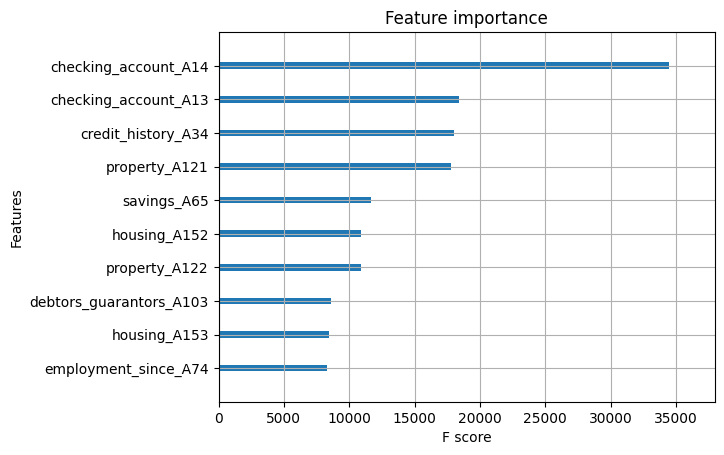

In [20]:
xgb.plot_importance(xgc, importance_type="gain", max_num_features=10, show_values=False);

Based on the above we see that the top three features driving the predictions of the model are:

* checking_account_A14 - lack of a checking account
* credit_history_A34 - critical account / has credits outside of the bank
* property_A121 - real estate

We could also look at the other importance metrics, just for completeness.

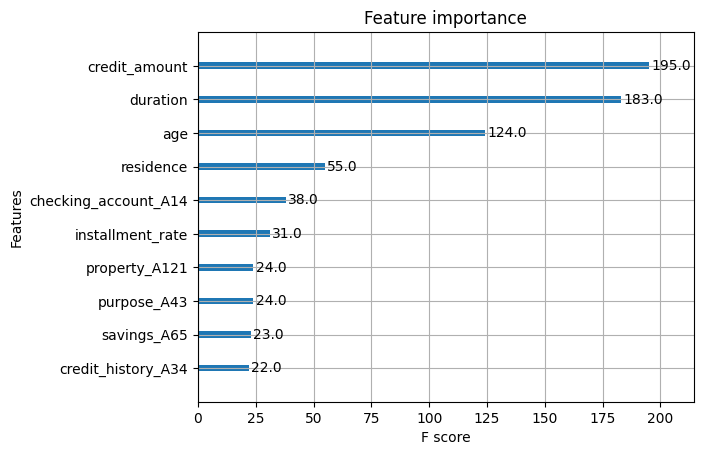

In [21]:
xgb.plot_importance(xgc, importance_type="weight", max_num_features=10);

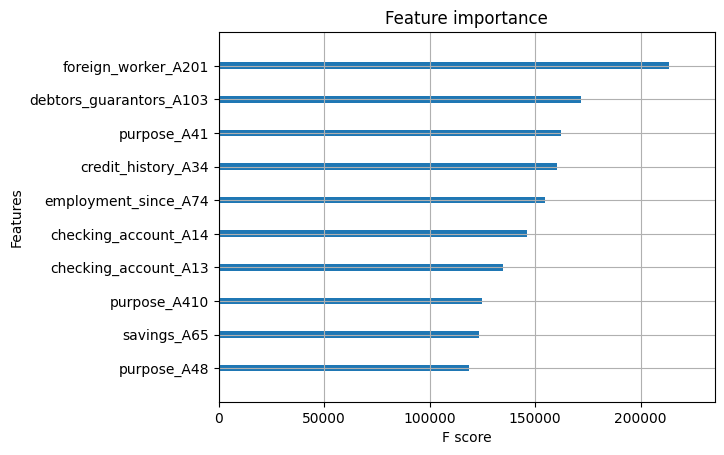

In [22]:
xgb.plot_importance(xgc, importance_type="cover", max_num_features=10, show_values=False);

ELI5 is another popular libarary for model explainability. This package is used to debug machine learning classifiers and explain their predictions. 

Unlike XGBoost, which is confined to explaining its own models only, ELI5 provides support for other frameworks like *scikit-learn*, *Keras*, *LightGBM* and others. It can also explain black-box models (i.e. Neural Networks) using [LIME](https://www.dominodatalab.com/blog/explaining-black-box-models-using-attribute-importance-pdps-and-lime).

First, ELI5 also provides a way of calculating the feature importance. Let's test it and make sure it agrees with the original XGBoost calculation (based on gain).

In [23]:
eli5.show_weights(xgc)

Weight,Feature
0.0954,checking_account_A14
0.0508,checking_account_A13
0.0498,credit_history_A34
0.0493,property_A121
0.0322,savings_A65
0.0302,housing_A152
0.0300,property_A122
0.0237,debtors_guarantors_A103
0.0234,housing_A153
0.0229,employment_since_A74


A more interesting function is `show_predictions`, which returns an explanation of the decision behind individual predictions. In other words, we can see what features drove the model to predict one outcome or the other.

Feel free to experiment with the code below, changing the `id` value and observing what features the model uses to calculate its prediction, and if the prediction agrees with the actual value. The `id` variable represents an observation number from the test dataset.

In [24]:
id = 3 # <- change this to see results for different observations  

print("Actual Label: %s" % actuals.iloc[id])
print("Predicted: %s" % pred_class[id])
eli5.show_prediction(xgc, df_test_X.iloc[id], 
                     feature_names=list(df_test_X.columns),
                     show_feature_values=True)


Actual Label: 1
Predicted: 1


This concludes the model training notebook demo.

In [25]:
# Set some default values
column_names_all = ['duration', 'credit_amount', 'installment_rate', 'residence', 'age', 'credits', 'dependents', 'checking_account_A11', 'checking_account_A12', 'checking_account_A13', 'checking_account_A14', 'credit_history_A30', 'credit_history_A31',
                    'credit_history_A32', 'credit_history_A33', 'credit_history_A34', 'purpose_A40', 'purpose_A41', 'purpose_A410', 'purpose_A42', 'purpose_A43', 'purpose_A44', 'purpose_A45', 'purpose_A46', 'purpose_A48', 'purpose_A49', 'savings_A61', 
                    'savings_A62', 'savings_A63', 'savings_A64', 'savings_A65', 'employment_since_A71', 'employment_since_A72', 'employment_since_A73', 'employment_since_A74', 'employment_since_A75', 'status_A91', 'status_A92', 'status_A93', 'status_A94', 
                    'debtors_guarantors_A101', 'debtors_guarantors_A102', 'debtors_guarantors_A103', 'property_A121', 'property_A122', 'property_A123', 'property_A124', 'other_installments_A141', 'other_installments_A142', 'other_installments_A143', 'housing_A151', 
                    'housing_A152', 'housing_A153', 'job_A171', 'job_A172', 'job_A173', 'job_A174', 'telephone_A191', 'telephone_A192', 'foreign_worker_A201', 'foreign_worker_A202']

sample_data = [[0.4705882352941176, 0.3685484758446132, 0.3333333333333333, 0.3333333333333333, 
                0.2857142857142857, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 
                1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 
                1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 
                1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0]]

In [26]:
df_all = pd.DataFrame(sample_data, columns=column_names_all)

In [27]:
for col in ['checking_account_A11', 'checking_account_A12', 'checking_account_A13', 'checking_account_A14', 
                'credit_history_A30', 'credit_history_A31', 'credit_history_A32', 'credit_history_A33', 
                'credit_history_A34', 'purpose_A40', 'purpose_A41', 'purpose_A410', 'purpose_A42', 'purpose_A43', 
                'purpose_A44', 'purpose_A45', 'purpose_A46', 'purpose_A48', 'purpose_A49', 'savings_A61', 
                'savings_A62', 'savings_A63', 'savings_A64', 'savings_A65', 'employment_since_A71', 
                'employment_since_A72', 'employment_since_A73', 'employment_since_A74', 'employment_since_A75', 
                'status_A91', 'status_A92', 'status_A93', 'status_A94', 'debtors_guarantors_A101', 
                'debtors_guarantors_A102', 'debtors_guarantors_A103', 'property_A121', 'property_A122', 
                'property_A123', 'property_A124', 'other_installments_A141', 'other_installments_A142', 
                'other_installments_A143', 'housing_A151', 'housing_A152', 'housing_A153', 'job_A171', 'job_A172', 
                'job_A173', 'job_A174', 'telephone_A191', 'telephone_A192', 'foreign_worker_A201', 'foreign_worker_A202']:
    df_all[col] = df_all[col].astype('int')


In [28]:
eli5.show_prediction(xgc, df_all.iloc[0], 
                         feature_names=list(df_all.columns),
                         show_feature_values=True)

In [29]:
df_all.iloc[0]

duration               0.470588
credit_amount          0.368548
installment_rate       0.333333
residence              0.333333
age                    0.285714
                         ...   
job_A174               1.000000
telephone_A191         0.000000
telephone_A192         1.000000
foreign_worker_A201    1.000000
foreign_worker_A202    0.000000
Name: 0, Length: 61, dtype: float64

In [30]:
df_all.iloc[0]["checking_account_A14"]

0.0

In [31]:
df_prediction = eli5.explain_prediction_df(xgc, df_all.iloc[0], 
                         feature_names=list(df_all.columns))

In [32]:
df_prediction.head(10).style.background_gradient(cmap = "Greens").hide()

target,feature,weight,value
y,purpose_A41,1.025946,1.000000
y,age,0.608093,0.285714
y,credit_amount,0.380752,0.368548
y,checking_account_A11,0.227235,0.000000
y,status_A93,0.190052,1.000000
y,installment_rate,0.171782,0.333333
y,telephone_A192,0.088084,1.000000
y,employment_since_A72,0.080591,0.000000
y,employment_since_A73,0.069443,1.000000
y,property_A123,0.053050,1.000000
